## Parameter estimation with discovery and nessai

Nessai is a nested sampling library that can be used for Bayesian inference. It is particularly useful for problems with complex posterior distributions as it uses a learned normalizing flow to efficiently sample from the posterior, thus reducing the number of likelihood evaluations required and increasing robustness to multi-modal posteriors. Generally, Nessai is one of the most robust samplers out there.

An additional advantage of using Nessai is that it can be used for both parameter estimation and model selection. This means that we can use it to compare different models for the same data, or to compare different datasets for the same model.

This notebook demonstrates parameter estimation for pulsar timing data using the Discovery and Nessai libraries. It covers loading pulsar data, constructing likelihood models, defining priors, and running the nested sampling. Visualization of sampling results is provided through trace and corner plots. The workflow is modular and can be adapted for different pulsar datasets and model configurations.

In [2]:
import discovery as ds
import glob

from discoverysamplers.nessai_interface import DiscoveryNessaiBridge

Let's get started by importing some (NanoGrav) pulsars and building a toy likelihood model. In our example we build a simple model with 3 pulsars, each with a power-law red noise process, giving us a total of 6 parameters to sample over (2 per pulsar). We fix the other parameters for simplicity.

In [3]:
import os

# Load pulsars from discovery by finding it's location
discovery_location = os.path.dirname(ds.__file__)

print("Found discovery package at:", discovery_location)

allpsrs = [ds.Pulsar.read_feather(psrfile) for psrfile in sorted(glob.glob(f'{discovery_location}/../../data/*-[JB]*.feather'))]

print(f"Loaded {len(allpsrs)} pulsars from feather files.")

psrs = allpsrs[:3]

print("Building likelihood for 3 pulsars...")

m = ds.ArrayLikelihood([ds.PulsarLikelihood([psr.residuals,
                                        ds.makenoise_measurement(psr, psr.noisedict),
                                        ds.makegp_ecorr(psr, psr.noisedict),
                                        ds.makegp_timing(psr, svd=True),
                                        ds.makegp_fourier(psr, ds.powerlaw, components=30, name='rednoise')])
                for psr in psrs])
print("...done.")

Found discovery package at: /Users/jeg/Documents/discovery/discovery/src/discovery
Loaded 67 pulsars from feather files.
Building likelihood for 3 pulsars...
...done.


Let's print the parameters of the pulsars we loaded:

In [4]:

m.logL.params

['B1855+09_rednoise_gamma',
 'B1855+09_rednoise_log10_A',
 'B1937+21_rednoise_gamma',
 'B1937+21_rednoise_log10_A',
 'B1953+29_rednoise_gamma',
 'B1953+29_rednoise_log10_A']

To make our plots look nice, we can also add some LaTex labels to the parameters (this is optional):

In [5]:
# Make Latex labels for parameters
latex_labels = {}
for param in m.logL.params:
    if 'log10_A' in param:
        pulsar_name = param.split('_rednoise_')[0]
        latex_labels[param] = r"$\log_{10} A_{" + pulsar_name + r"}$"
    elif 'gamma' in param:
        pulsar_name = param.split('_rednoise_')[0]
        latex_labels[param] = r"$\gamma_{" + pulsar_name + r"}$"
    else:
        latex_labels[param] = param

print("LaTex labels:")
for param, label in latex_labels.items():
    print(f"  {param}: {label}")

LaTex labels:
  B1855+09_rednoise_gamma: $\gamma_{B1855+09}$
  B1855+09_rednoise_log10_A: $\log_{10} A_{B1855+09}$
  B1937+21_rednoise_gamma: $\gamma_{B1937+21}$
  B1937+21_rednoise_log10_A: $\log_{10} A_{B1937+21}$
  B1953+29_rednoise_gamma: $\gamma_{B1953+29}$
  B1953+29_rednoise_log10_A: $\log_{10} A_{B1953+29}$


Let's also define some priors (note that the priors must be defined over all parameters in the model)

In [6]:

priors = {
    'B1855+09_rednoise_gamma': {'dist': 'uniform', 'min': 0, 'max': 7},
    'B1855+09_rednoise_log10_A': {'dist': 'uniform', 'min': -20, 'max': -11},
    'B1937+21_rednoise_gamma': {'dist': 'uniform', 'min': 0, 'max': 7},
    'B1937+21_rednoise_log10_A': {'dist': 'fixed', 'value': -13.5},
    'B1953+29_rednoise_gamma': {'dist': 'fixed', 'value': 3},
    'B1953+29_rednoise_log10_A': {'dist': 'uniform', 'min': -20, 'max': -11},
}

Let's take a moment to look at the priors we've defined and what they mean:

- Each of the six parameters is denoted by the same name as in the model (the return of `m.logL.params`)
- For each parameter we can define a prior distribution. The easiest way to do that is to pass a dictionary with the following keys:
  - `dist`: the type of distribution. Currently supported are `uniform`, `loguniform` and `fixed` (for fixed parameters)
  - What comes after depends on the distribution type:
    - For `uniform` we need to define `min` and `max` values
    - For `loguniform`, we need `a` and `b` values (see scipy.stats.loguniform for details)
    - For `fixed`, we need to specify a `value`
- If we specify `fixed` for a parameter, it will not be sampled over, and will be held fixed at the specified value.

Now that we have a model, priors and LaTex labels, we can create the `DiscoveryErynBridge` object. This object will handle the interface between discovery and Eryn, and will allow us to run the sampler.

In [ ]:
bridge = DiscoveryNessaiBridge(m, priors=priors, latex_labels=latex_labels)

Internally, the `DiscoveryNessaiBridge` object will determine the number of parameters to sample over, set up the likelihood and prior functions, and prepare everything for Nessai.

The only thing left for us to do is to initialize and run the sampler. The create_sampler method internally initializes a FlowSampler object from Nessai so you can pass the same arguments as you would to Nessai's FlowSampler.

In [ ]:
bridge.run_sampler(output='nessai_test')

/opt/homebrew/Caskroom/miniconda/base/envs/PTAEnterprise/lib/python3.10/site-packages/nessai/gw/__init__.py:12: FutureWarning: The `nessai.gw` module will be deprecated in the next release in favour of the nessai-gw package. This packages provides the same functionality as`nessai.gw` via the plugin interface.For more details, see: https://github.com/mj-will/nessai-gw
  warnings.warn(


Now that we've run the sampler we can analyze the results!

The run_sampler method returns the sampler (EnsembleSampler) object from Eryn, which contains the chain and other information about the sampling run. You can access the 
chain via `sampler.chain`, which is a dict with a 5-dimensional array with shape (nsteps, ntemps, nwalkers, max_nleaves, nparams) for each model. Now obviously this is a bit annoying
to deal with so I've included some helper methods in the `DiscoveryErynBridge` class to make it easier to extract and analyze the samples.

- If you call `bridge.return_all_samples()` it will return a dict with the 5d array of samples for the model including all fixed parameters.
- If you call `bridge.return_sampled_samples()` it will return a dict with the 5d array of samples for the model but only including the parameters that were sampled over (i.e. excluding fixed 
  parameters).

In addition, both dicts will also include a `names` and a `labels` list with the parameter names and LaTex labels of the samples in the same order as the last axis of the 5d array.

Let's show you the difference:

In [11]:
# Get the chain samples from the dict
samples = bridge.return_sampled_samples()
print("Only sampled parameters:")
print(samples["names"])
print(samples["chain"].shape) 

samples_all = bridge.return_all_samples()
print("All parameters:")
print(samples_all["names"])
print(samples_all["chain"].shape)

Only sampled parameters:
['B1855+09_rednoise_gamma', 'B1855+09_rednoise_log10_A', 'B1937+21_rednoise_gamma', 'B1953+29_rednoise_log10_A']
(3841, 4)
All parameters:
['B1855+09_rednoise_gamma', 'B1855+09_rednoise_log10_A', 'B1937+21_rednoise_gamma', 'B1937+21_rednoise_log10_A', 'B1953+29_rednoise_gamma', 'B1953+29_rednoise_log10_A']
(3841, 6)


You see that we only sampled over 4 parameters, since we fixed the a parameter each for B1937+21 and B1953+29.
    
Now we can also plot the traces of the sampled parameters using the built-in plotting function. Note that this function plots the traces for each temperature separately, 
so you will see 3 traces for each parameter in our case since we used 3 temperatures.

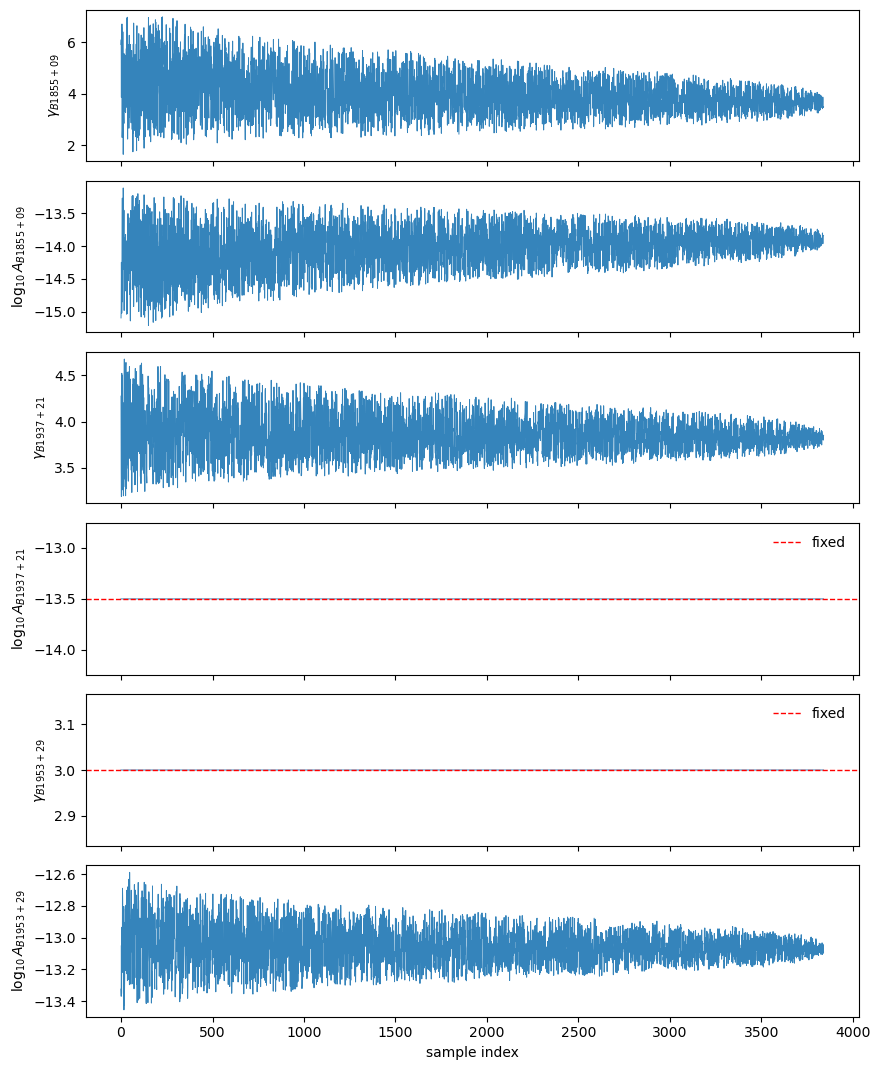

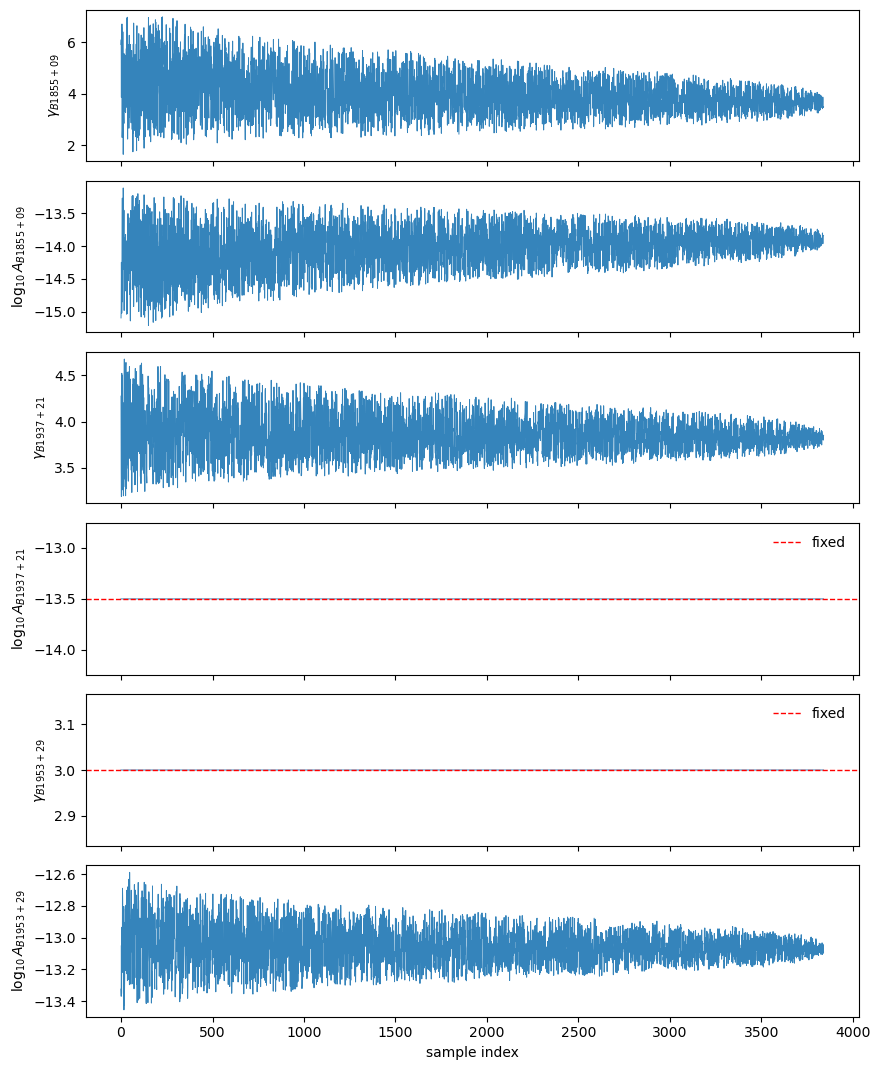

In [15]:
import matplotlib.pyplot as plt
fig = bridge.plot_trace(plot_fixed=True)
plt.show()

Similarly, we can also plot the corner plot of the sampled parameters using the built-in plotting function. Again, this function plots the samples for each temperature separately, so you will see 3 contours for each pair of parameters in our case since we used 3 temperatures.

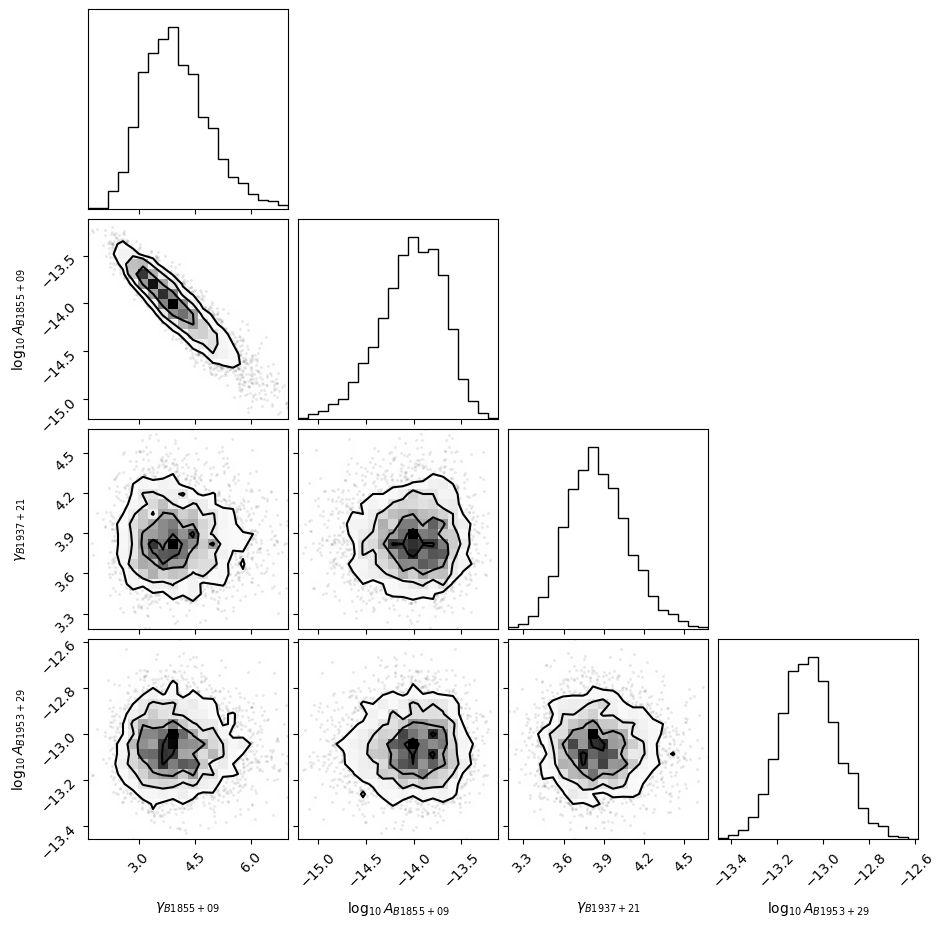

In [16]:
fig2 = bridge.plot_corner()
plt.show()